In [1]:
import os, code, sys, time
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L 
import chainer.optimizers as optimizers
from chainer import cuda
import cupy
from IPython import display
from data_utils import load_data, normalize, next_minibatch, to_variable
import models, nn, graph_ops

In [2]:
'''
Set array backend, seed
'''
def seed_rng(s):
    xp.random.seed(s)
    np.random.seed(s)
rng_seed = 98765
use_gpu = True
xp = cupy if use_gpu >= 0 else np
print('xp: {}'.format(xp))
print('rng_seed = {} '.format(rng_seed))

xp: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>
rng_seed = 98765 


In [ ]:
'''
Hyperparameter search
'''
from IPython.display import clear_output
from prettytable import PrettyTable

num_particles = 16 # defaults 16**3
lr = 0.01
mb_size = 8
n_epochs = 2500
chan_vals = [2**i for i in range(2,9)]
chan_depth = [i for i in range(2,15)]
#chans = [np.random.choice(chan_vals, np.random.choice(chan_depth)) for i in range(1000)]
#bounds = [0.0, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
#redshifts = [(0.4, 0.0), (0.8, 0.0), (6.0, 1.2), (4.0, 2.0), (0.8, 0.6), (1.5, 1.0), (1.2, 0.2), (6.0, 0.4)]
n_NN = list(np.arange(8,31))
n_NN.insert(0,0)
redshifts = [(0.4, 0.0), (6.0, 0.0), (4.0, 0.6), (0.8, 0.2), (1.0, 0.4), (2.0, 0.8), (6.0, 1.5), (1.2, 0.6), (2.0, 1.5), (0.4, 0.2)]
search_params = n_NN
param_label = "n_NN"

def pprint_avgs(arr):
    #lst = [list(row) for row in list(arr)]
    lst = [['%0.7f'%elem for elem in row] for row in arr]
    ptab = PrettyTable()
    ptab.field_names = [param_label] + [str(rs) for rs in redshifts]
    for idx, row in enumerate(lst):
        param = search_params[idx]
        ptab.add_row([param] + row)
    print(ptab)

#specs = [('knn', 9),('knn', 11),('knn', 13),('knn', 15),('knn', 17),('knn', 21),('knn', 23),('knn', 25),('knn', 27), ]
loss_history = np.zeros((n_epochs,len(search_params),len(redshifts)), dtype=np.float32)
loss_avgs = np.zeros((len(search_params), len(redshifts)))
'''
for rs_idx, rs in enumerate(redshifts):
    zX, zY = rs
    _X,_Y = load_data(zX, zY, num_particles)
'''
for p_idx, PARAM in enumerate(search_params):
    for rs_idx, rs in enumerate(redshifts):
        # MUST SEED BEFORE EACH TRAINING SESSION
        seed_rng(rng_seed) # insure that every model begins with same
        zX, zY = rs
        _X,_Y = load_data(zX, zY, num_particles)
        X,Y = np.copy(_X), np.copy(_Y)
        X = normalize(X)
        Y = normalize(Y)
        chan = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3]
        if p_idx == 0:
            model = models.nBodyModel(chan)
        else:
            model = models.nBodyModel(chan, ('knn', PARAM))
        model.to_gpu()
        optimizer = optimizers.Adam(alpha=lr)
        optimizer.setup(model)
        
        cur_settings = [PARAM, rs]
        print('param: {}, zX, zY: {}'.format(PARAM, (zX,zY)))
        for epoch in range(1, n_epochs+1):
            model.zerograds()
            # data
            _x_in_, _x_true_ = next_minibatch([X,Y], mb_size)
            _x_in, _x_true = np.copy(_x_in_), np.copy(_x_true_)
            x_in = chainer.Variable(cuda.to_gpu(_x_in.astype(xp.float32)))
            x_true = chainer.Variable(cuda.to_gpu(_x_true.astype(xp.float32)))
            # forward
            x_hat = model(x_in, add=True, bounded=True) # prediction
            loss = nn.loss_fun_bounded(x_hat, x_true, 0.095)
            # backprop
            loss.backward()
            optimizer.update()
            loss_history[epoch-1, p_idx, rs_idx] = cuda.to_cpu(loss.data)
        endloss = np.mean(loss_history[-250:, p_idx, rs_idx])
        loss_avgs[p_idx, rs_idx] = endloss
        rsf = (endloss, cur_settings)
        clear_output(wait=True)
        pprint_avgs(loss_avgs)
           
'''
+--------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| bounds |     (0.4, 0.0)    |     (0.8, 0.0)    |     (6.0, 1.2)    |     (4.0, 2.0)    |     (0.8, 0.6)    |     (1.5, 1.0)    |     (1.2, 0.2)    |
+--------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|  0.0   | 0.000119890377391 | 0.000457710237242 | 0.000162970478414 | 1.83323718375e-05 | 3.16315745295e-05 | 3.01272466459e-05 | 0.000394351867726 |
|  0.1   | 0.000115659378935 | 0.000500292750075 | 0.000203645016882 | 1.69450759131e-05 | 9.24624055187e-06 |  2.8423832191e-05 | 0.000487153010909 |
|  0.09  | 0.000115799157356 | 0.000559969630558 |  0.00023882460664 | 1.74512952071e-05 | 9.26273605728e-06 | 2.84684101644e-05 | 0.000572036020458 |
|  0.08  | 0.000116949391668 | 0.000655652140267 | 0.000299750536215 | 1.96377641259e-05 | 9.30869464355e-06 | 2.90543866868e-05 | 0.000710388296284 |
|  0.07  | 0.000120661708934 |  0.00084223295562 | 0.000426335580414 | 2.46218041866e-05 | 9.20692764339e-06 | 3.07395057462e-05 | 0.000908661459107 |
|  0.06  | 0.000139344963827 |  0.00122337543871 | 0.000728332379367 | 3.16597470373e-05 | 9.24199503061e-06 | 3.68279579561e-05 |  0.00116449513007 |
|  0.05  | 0.000196880107978 |  0.00139848690014 |  0.00132458866574 | 4.45803343609e-05 | 3.16621590173e-05 | 5.26102048752e-05 |  0.0013643016573  |
|  0.04  | 0.000389787834138 |  0.00283175101504 |  0.00187213870231 | 6.82938407408e-05 | 3.19446407957e-05 | 9.32425173232e-05 |  0.00223632133566 |
|  0.03  |  0.00107194168959 |  0.00341849774122 |  0.00439322041348 | 0.000150620136992 | 3.74845330953e-05 | 0.000194006090169 |  0.00389076955616 |
|  0.01  |  0.00541484635323 |  0.0116537790745  |  0.00976342987269 |  0.00506438920274 | 0.000540107314009 |  0.00248598889448 |  0.0114512173459  |
| 0.009  |  0.00684926938266 |  0.0126220276579  |   0.017486480996  |  0.00599138485268 | 0.000731166161131 |  0.0032100409735  |  0.0155507419258  |
+--------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| n_NN | (0.4, 0.0) | (6.0, 0.0) | (4.0, 0.6) | (0.8, 0.2) | (1.0, 0.4) | (2.0, 0.8) | (6.0, 1.5) | (1.2, 0.6) | (2.0, 1.5) | (0.4, 0.2) |
+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|  8   | 0.0001029  | 0.0054619  | 0.0008854  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  9   | 0.0001110  | 0.0054512  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  10  | 0.0000974  | 0.0051782  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  11  | 0.0000966  | 0.0055355  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  12  | 0.0000998  | 0.0055162  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  13  | 0.0000977  | 0.0056525  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  14  | 0.0000968  | 0.0056713  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  15  | 0.0000982  | 0.0054596  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  16  | 0.0000995  | 0.0050161  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  17  | 0.0000974  | 0.0054068  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  18  | 0.0000987  | 0.0049583  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  19  | 0.0000972  | 0.0050308  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  20  | 0.0000970  | 0.0055209  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  21  | 0.0001003  | 0.0051587  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  22  | 0.0000975  | 0.0050356  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  23  | 0.0000959  | 0.0052206  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
'''
cat = 'cat'

+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| n_NN | (0.4, 0.0) | (6.0, 0.0) | (4.0, 0.6) | (0.8, 0.2) | (1.0, 0.4) | (2.0, 0.8) | (6.0, 1.5) | (1.2, 0.6) | (2.0, 1.5) | (0.4, 0.2) |
+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|  0   | 0.0001158  | 0.0024041  | 0.0008920  | 0.0002067  | 0.0001298  | 0.0002501  | 0.0000939  | 0.0000725  | 0.0000123  | 0.0000146  |
|  8   | 0.0001038  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  9   | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  10  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  | 0.0000000  |
|  11  | 0.0000000  | 0.000

In [6]:
avgs_by_bound = np.mean(loss_avgs, axis=1)
avgs_by_redshift = np.mean(loss_avgs, axis=0)

In [1]:
bounds[np.argmin(avgs_by_bound)]

NameError: name 'bounds' is not defined

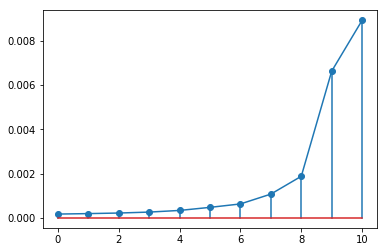

In [27]:
avgs = avgs_by_bound
plt.clf()
plt.plot(avgs)
plt.stem(avgs)
plt.show()